# This sample code is used to test the integration of STAIG on two MERFISH datasets.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/nvidia0
/dev/nvidiactl:      root      mount /dev/nvidiactl
sh: 1: kill: Illegal number: kernelkernelkernelkernel


### Step 1: Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatchAdata
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    dataset='merfish',
    slide='vertical_merfish',
    config='train_no_img_config.yaml',
    label=False,
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]
slide_path = os.path.join(file_fold, args.dataset)

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
torch.use_deterministic_algorithms(True)

data1 = sc.read_h5ad("./Dataset/merfish/mouse1.AUD_TEA_VIS.242.unexpand_cluster3.h5ad")
data2 = sc.read_h5ad("./Dataset/merfish/mouse2.AUD_TEA_VIS.242.unexpand_cluster3.h5ad")
filelist = [data1,data2]

data = LoadBatchAdata(dataset_path='',file_list = filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=False, label = args.label).run()

columns_to_drop = [col for col in data.var.columns if col not in ['means', 'variances']]


data.var = data.var.drop(columns=columns_to_drop)
print(data)



AnnData object with n_obs × n_vars = 5995 × 234
    obs: 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'spatial_cluster'
    uns: 'cluster_L2_colors'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2479 × 234
    obs: 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'spatial_cluster'
    uns: 'cluster_L2_colors'
    obsm: 'spatial'
load all slices done
merge done


Calculating distances: 100%|██████████| 8474/8474 [00:26<00:00, 324.91it/s]


AnnData object with n_obs × n_vars = 8474 × 234
    obs: 'fov.x', 'fov.y', 'cluster_L1', 'cluster_L2', 'cluster_L3', 'spatial_cluster', 'batch'
    obsm: 'spatial', 'local_graph', 'feat', 'graph_neigh', 'mask_neigh', 'edge_probabilities'


In [4]:
staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.mask_slices = True
staig.train()
staig.eva()



=== prepare for training ===
Consider intra slice
=== train ===


100%|██████████| [04:42<00:00,  1.42it/s]


=== load ===
[[ 1.29074668 -2.96516914 -1.20651206 ...  2.43830695 -0.57938566
  -0.50277008]
 [ 1.14638411 -2.75260638 -1.40440378 ...  2.82824309 -0.57521289
  -0.61406227]
 [ 0.88280422 -2.94299944 -1.27594874 ...  2.34326037 -0.41735119
  -0.27149163]
 ...
 [ 0.79245147 -0.38647783  2.37498442 ... -1.16577138  0.85811984
   1.15373849]
 [ 0.79245147 -0.38647783  2.37498442 ... -1.16577138  0.85811984
   1.15373849]
 [ 0.19804445 -0.59335732  2.37869187 ... -2.48124011  0.52987744
   1.10094217]]
embedding generated, go clustering


### Step 3: Show results

In [5]:
staig.cluster(args.label)

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%
calculate SC and DB
SC: 0.40782451929779573
DB: 0.8715976321465853
BatchKL= [0.2521036]
Median ILISI: 1.54


### Step 4: Show clusters

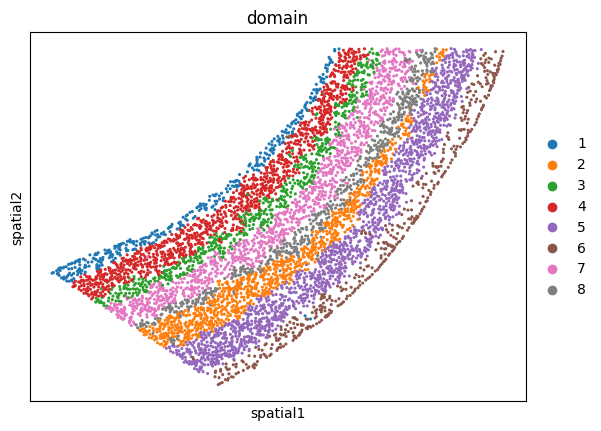

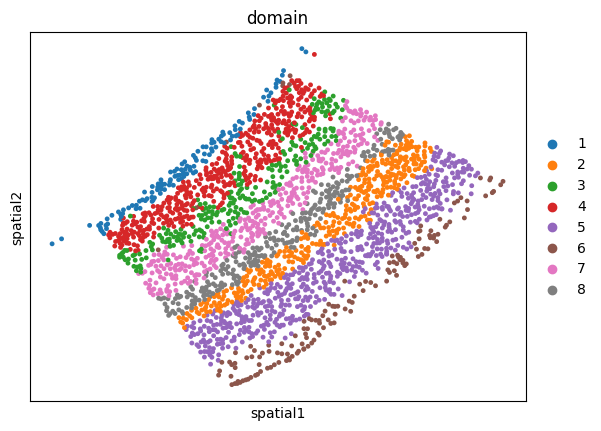

In [6]:
sc.pl.embedding(staig.adata[staig.adata.obs['batch'] == '0'], basis="spatial", color="domain",show=True,save='merfish0.pdf')
sc.pl.embedding(staig.adata[staig.adata.obs['batch'] == '1'], basis="spatial", color="domain",show=True,save='merfish1.pdf')

### Step 5: Show UMAP

start umap


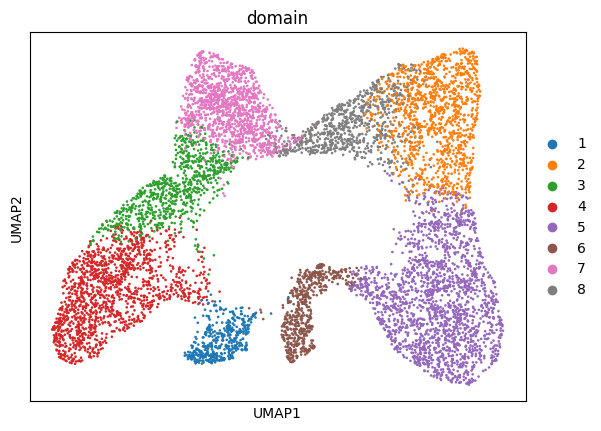

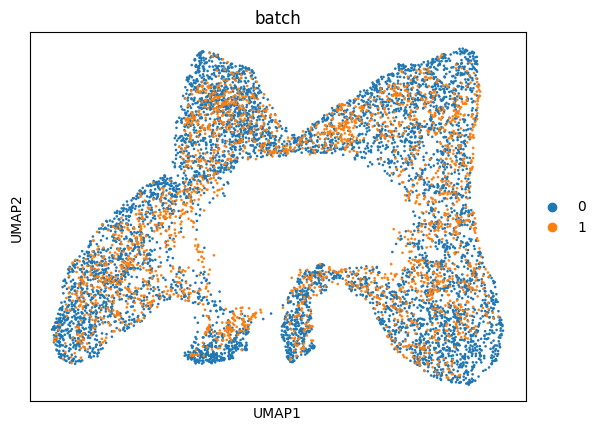

In [7]:
staig.draw_umap()